# Google Maps Static API

In [ ]:
import requests
from PIL import Image
from io import BytesIO

In [60]:
with open('../data/api_keys.json', 'r') as file:
    keys = json.load(file)

maps_api_key = keys['Google']
geonames_username = keys['Geonames']

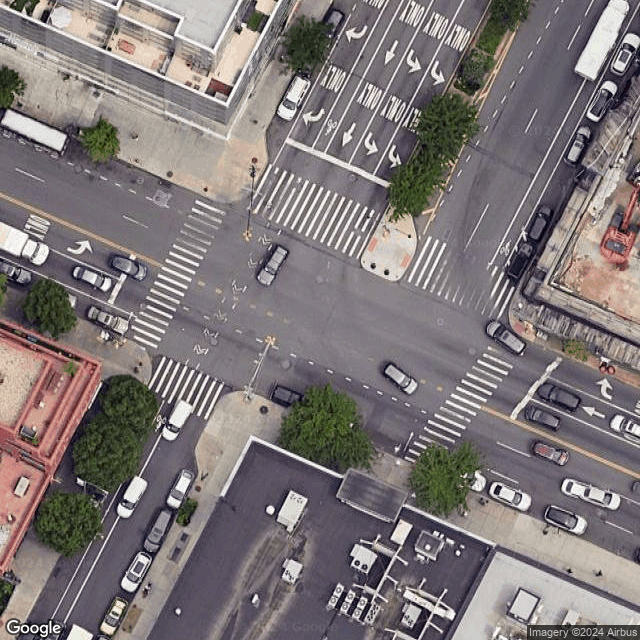

In [61]:
def get_satellite_image(lat, lon, zoom=20, size="640x640", map_type="satellite"):
    base_url = "https://maps.googleapis.com/maps/api/staticmap"
    params = {
        "center": f"{lat},{lon}",
        "zoom": zoom,
        "size": size,
        "maptype": map_type,
        "key": maps_api_key
    }
    response = requests.get(base_url, params=params)
    image = Image.open(BytesIO(response.content))
    return image

# Example: Fetching an image of Boerum Place
latitude = 40.68912641385102
longitude = -73.99060296456825

image = get_satellite_image(latitude, longitude)
display(image)
# image.show()  # This will display the image
image.save("sample_img.png")  # Save the image if needed

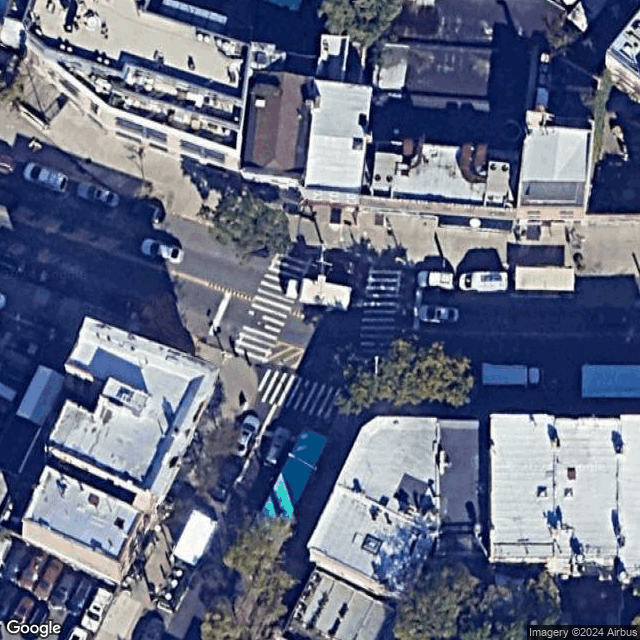

In [75]:
img = get_satellite_image(40.71409718754403, -73.95599759116811, zoom=20)
display(img)

In [67]:
import numpy as np
import torch
from torchvision import transforms
from torchvision.transforms import functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import CocoDetection

from PIL import Image
from IPython.display import display
import cv2

In [63]:
def load_image_as_tensor(image_path, input_size=(1000,1000)):
    """
    Load an image, resize it, and convert it to a PyTorch tensor.
    :param image_path: Path to the image file.
    :param input_size: Desired input size for the model (width, height).
    """
    # Establish pipeline
    transform_pipeline = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor()
    ])
    # Load image, covert to RGB, resize, and convert to tensor
    image = Image.open(image_path).convert('RGB')
    image = transform_pipeline(image)

    return image

In [64]:
def filter_predictions(predictions, interested_classes):
    # Filter out predictions to include only those in the interested_classes
    filtered_preds = []
    for prediction in predictions:
        mask = [True if label in interested_classes else False for label in prediction['labels']]
        filtered_pred = {key: value[mask] for key, value in prediction.items()}
        filtered_preds.append(filtered_pred)
    return filtered_preds

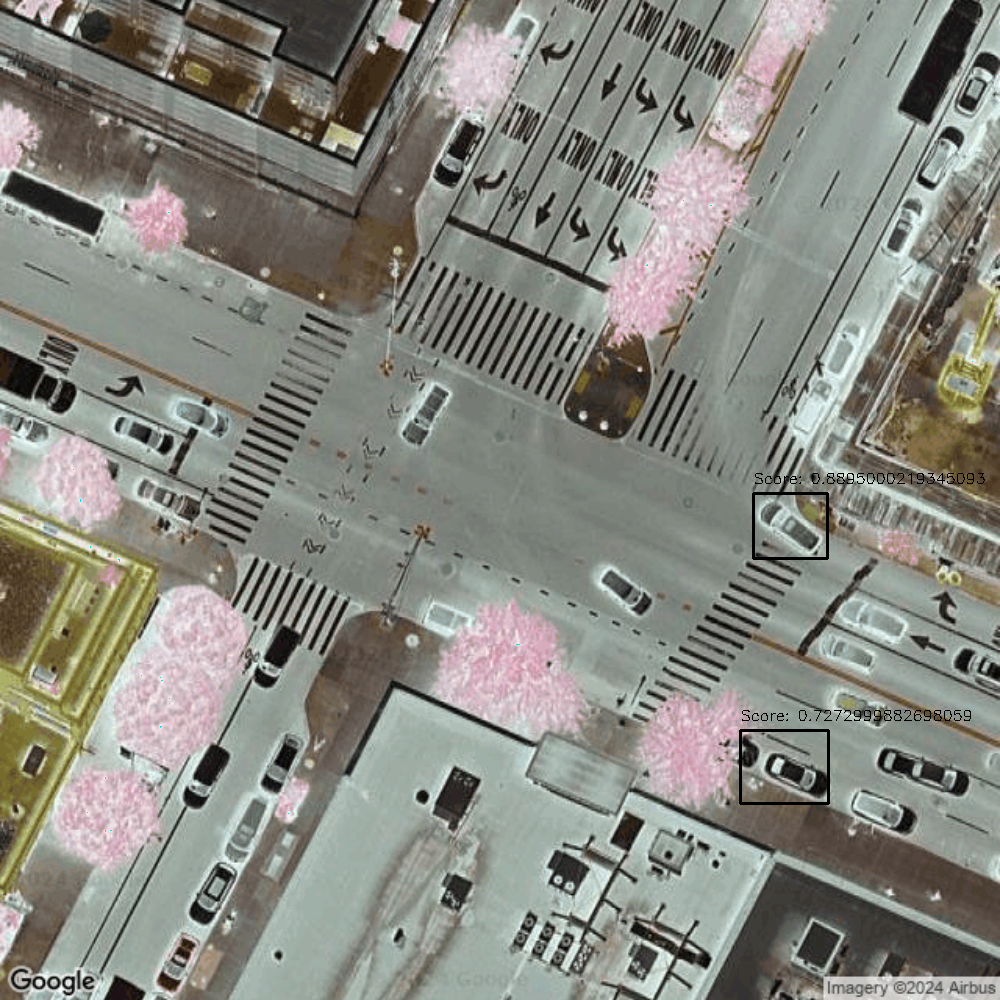

In [68]:
img_tensor = load_image_as_tensor('sample_img.png')

model = fasterrcnn_resnet50_fpn(weights='DEFAULT')
model.eval()
with torch.no_grad():
    prediction = model([img_tensor])

interested_classes = [1, 2, 3, 10]  # Person, bicycle, car, and traffic light
filtered_predictions = filter_predictions(prediction, interested_classes)

threshold = 0.5
prediction = filtered_predictions

image_np = img_tensor.permute(1, 2, 0).cpu().numpy()
image_np = cv2.cvtColor((image_np * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

for element in range(len(prediction[0]['boxes'])):
    boxes = prediction[0]['boxes'][element].cpu().numpy()
    score = np.round(prediction[0]['scores'][element].cpu().numpy(), decimals=4)
    
    if score > threshold:  # Filter out low-confidence detections
        cv2.rectangle(image_np, (int(boxes[0]), int(boxes[1])), (int(boxes[2]), int(boxes[3])), (0, 255, 0), 2)
        cv2.putText(image_np, f'Score: {score}', (int(boxes[0]), int(boxes[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

# Convert back to PIL image to easily display or save
image_with_boxes = Image.fromarray((image_np * 255).astype(np.uint8))

# Display or save the image
display(image_with_boxes)

# GEE

In [16]:
import ee
import geemap
from IPython.display import Image, display

In [3]:
ee.Authenticate()
ee.Initialize(project='ee-keithcolella')

In [7]:
# Define a point and date range
lat, lon = 40.760113, -73.87768
start_date = '2020-01-01'
end_date = '2020-01-31'

point = ee.Geometry.Point([lon, lat])

# Use the updated Sentinel-2 dataset
collection = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
              .filterDate(start_date, end_date)
              .filterBounds(point)
              .sort('CLOUDY_PIXEL_PERCENTAGE', False)
              .first())  # Get the first image

# Print the band names for the selected image
print(collection.bandNames().getInfo())  # This prints the available band names

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE']


In [10]:
def get_historical_image(lat, lon, start_date, end_date):
    # Define a point for the location
    point = ee.Geometry.Point([lon, lat])

    # Use the updated Sentinel-2 harmonized dataset
    collection = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
                  .filterDate(start_date, end_date)
                  .filterBounds(point)
                  .sort('CLOUDY_PIXEL_PERCENTAGE', False)
                  .first())  # Get the first image in the sorted collection

    # Select the RGB bands only (B4 = red, B3 = green, B2 = blue)
    rgb_image = collection.select(['B4', 'B3', 'B2'])

    # Set visualization parameters for RGB bands
    vis_params = {
        'min': 0,
        'max': 5000,  # Adjust based on the dataset's range
        'bands': ['B4', 'B3', 'B2']  # Use the selected RGB bands
    }

    # Get the image as a thumbnail
    thumbnail = rgb_image.getThumbURL({
        'region': point.buffer(300).bounds().getInfo()['coordinates'],  # Small buffer around the point
        'dimensions': '640x640',
        'format': 'png',
        'visParams': vis_params
    })

    return thumbnail

# Example usage: retrieve an image for the given date range and location
lat, lon = 40.760113, -73.87768
start_date = '2020-01-01'
end_date = '2020-01-31'

thumbnail_url = get_historical_image(lat, lon, start_date, end_date)

# You can download or display this thumbnail directly
print(f"Thumbnail URL: {thumbnail_url}")

Thumbnail URL: https://earthengine.googleapis.com/v1/projects/ee-keithcolella/thumbnails/cb669c8a1372f43f1fa9607a23b107b7-14bf9a7e945b9f41707ea3f92a2863d5:getPixels


In [47]:
# Define the image collection
dataset = ee.ImageCollection('SKYSAT/GEN-A/PUBLIC/ORTHO/RGB')

# Select the RGB bands
rgb = dataset.select(['R', 'G', 'B'])

# Define visualization parameters
rgb_vis = {
    'min': 11.0,
    'max': 190.0,
}

# Create a map centered on the desired location
lat = 40.6891
lon = -73.9906
map = geemap.Map(center=[41.6555, -70.892], zoom=15)

# Add the RGB layer to the map
map.addLayer(rgb, rgb_vis, 'RGB')

# Display the map
map.addLayerControl()
map

Map(center=[41.6555, -70.892], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [48]:
skysat_rgb = ee.ImageCollection("SKYSAT/GEN-A/PUBLIC/ORTHO/RGB")

point = ee.Geometry.Point([-102.17748642229708, 17.942153910452422])
filtered_collection = skysat_rgb.filterBounds(point).filterDate('2020-01-01', '2020-12-31')

vis_params = {
    'bands': ['R', 'G', 'B'],
    'min': 0,
    'max': 255,
    'gamma': 1.4
}
map = geemap.Map(center=[-102.17748642229708, 17.942153910452422], zoom=15)
map.centerObject(point, 14)
map.addLayer(filtered_collection.median(), vis_params, 'SkySat RGB')

map

Map(center=[17.942153910452422, -102.17748642229708], controls=(WidgetControl(options=['position', 'transparen…

In [33]:
display(image)

In [15]:
image1 = ee.Image(1)
print(image1)
print(image1.getInfo())

image2 = ee.Image(2)
image3 = ee.Image.cat([image1, image2])
print(image3.getInfo())

multiband = ee.Image([1, 2, 3])
print(multiband)
renamed = multiband.select(['constant','constant_1','constant_2'],['band1','band2','band3'])
print(renamed)
# Display the map.
Map

ee.Image({
  "functionInvocationValue": {
    "functionName": "Image.constant",
    "arguments": {
      "value": {
        "constantValue": 1
      }
    }
  }
})
{'type': 'Image', 'bands': [{'id': 'constant', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 1, 'max': 1}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}
{'type': 'Image', 'bands': [{'id': 'constant', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 1, 'max': 1}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'constant_1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 2, 'max': 2}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}
ee.Image({
  "functionInvocationValue": {
    "functionName": "Image.addBands",
    "arguments": {
      "dstImg": {
        "functionInvocationValue": {
          "functionName": "Image.addBands",
          "arguments": {
            "dstImg": {
              "functionInvocationValue": {
                "functionNa

NameError: name 'Map' is not defined

In [4]:
# Define a point for the intersection
point = ee.Geometry.Point([-74.0060, 40.7128])

# Get satellite image for the location
image = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterBounds(point) \
        .filterDate('2023-01-01', '2023-12-31') \
        .sort('CLOUD_COVER') \
        .first() \
        .select(['SR_B4', 'SR_B3', 'SR_B2'])

# Calculate min and max values over the region
stats = image.reduceRegion(
    reducer=ee.Reducer.percentile([1, 99]),
    geometry=point.buffer(1000),
    scale=30
).getInfo()

min_val = min([stats['SR_B4_p1'], stats['SR_B3_p1'], stats['SR_B2_p1']])
max_val = max([stats['SR_B4_p99'], stats['SR_B3_p99'], stats['SR_B2_p99']])

# Visualize the image with appropriate min/max values
url = image.getThumbURL({'min': min_val, 'max': max_val, 'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'region': point.buffer(1000).bounds().getInfo()})
print("Thumbnail URL:", url)


Thumbnail URL: https://earthengine.googleapis.com/v1/projects/ee-keithcolella/thumbnails/29c1ff5e71c4c0e890f1c7369522aac8-5ecd474eaa249257e232b284e60aa5f2:getPixels


https://sites.northwestern.edu/researchcomputing/2021/11/19/downloading-satellite-images-made-easy/

https://github.com/ageller/EarthEngineToGeoTIFF/blob/main/downloadChicagoMap.ipynb

In [45]:
import ee
import rasterio
from rasterio.plot import show as showRasterio

# my script
import sys
sys.path.append('../scripts')
from EarthEngineToGeoTIFF import getSentinalS2SRImage

import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'rasterio'

Creating 3-band GeoTIFF image ... 


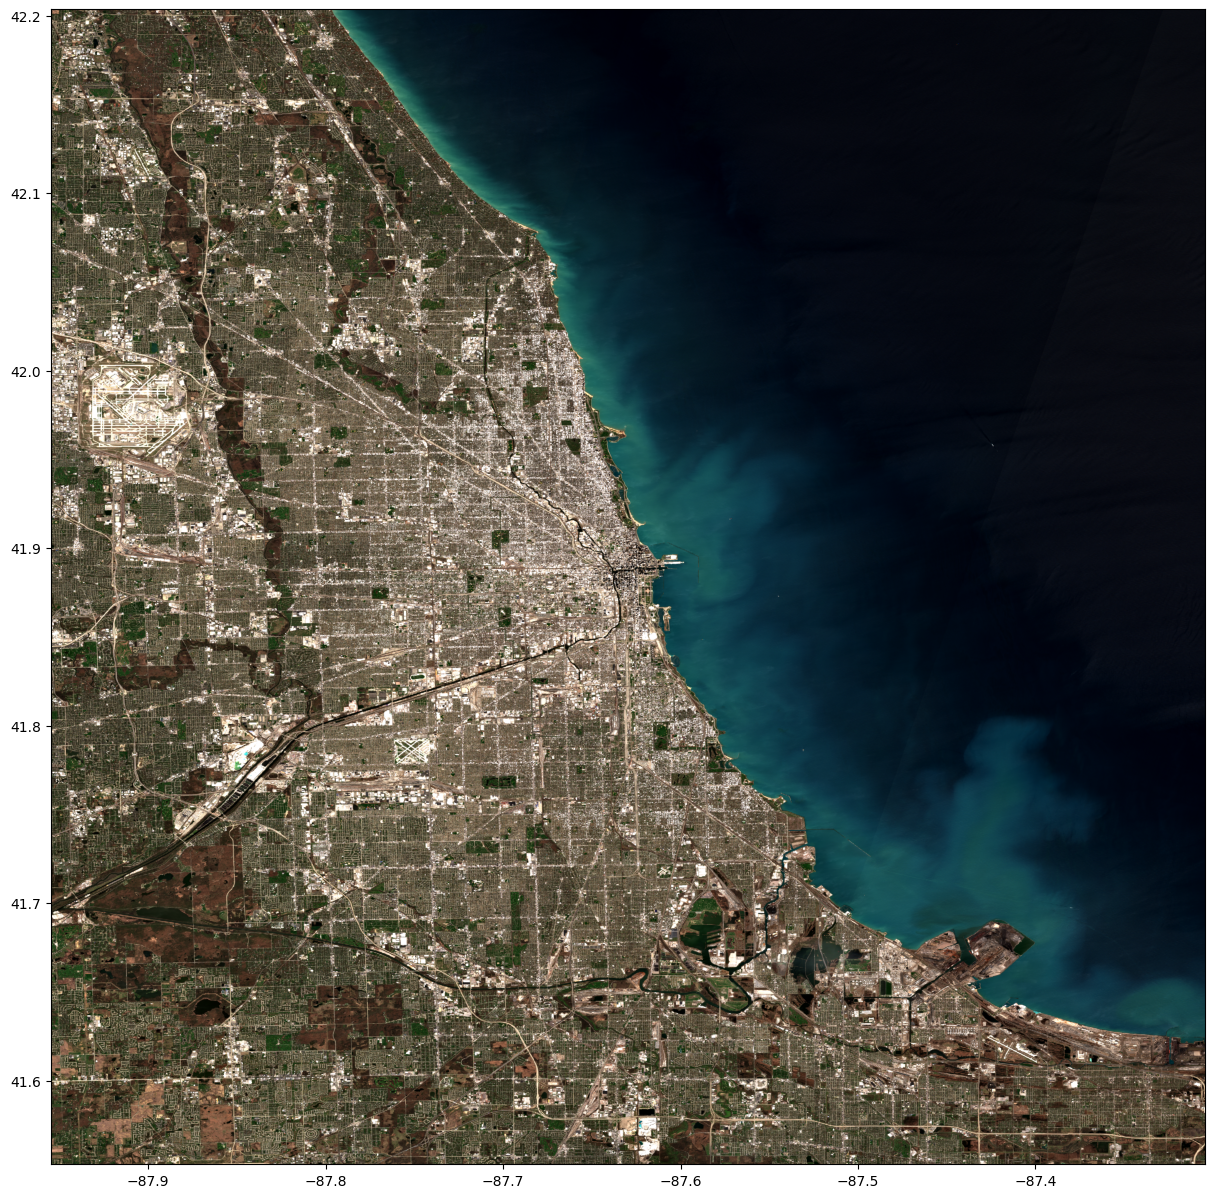

In [25]:
# Chicago central latitude, longitude and approximate size
lat = 41.8781
lon = -87.6298
sze = 0.65
_ = getSentinalS2SRImage(lon, lat, sze, 'ChicagoGeoTIFF.tif')

f, ax = plt.subplots(figsize=(15,15))

chicago = rasterio.open('ChicagoGeoTIFF.tif')
showRasterio(chicago.read(), ax = ax, transform=chicago.transform)

f.savefig('Chicago.png', bbox_inches='tight')

chicago.close()

# delete!
!rm ChicagoGeoTIFF.tif
!rm Chicago.png

Creating 3-band GeoTIFF image ... 


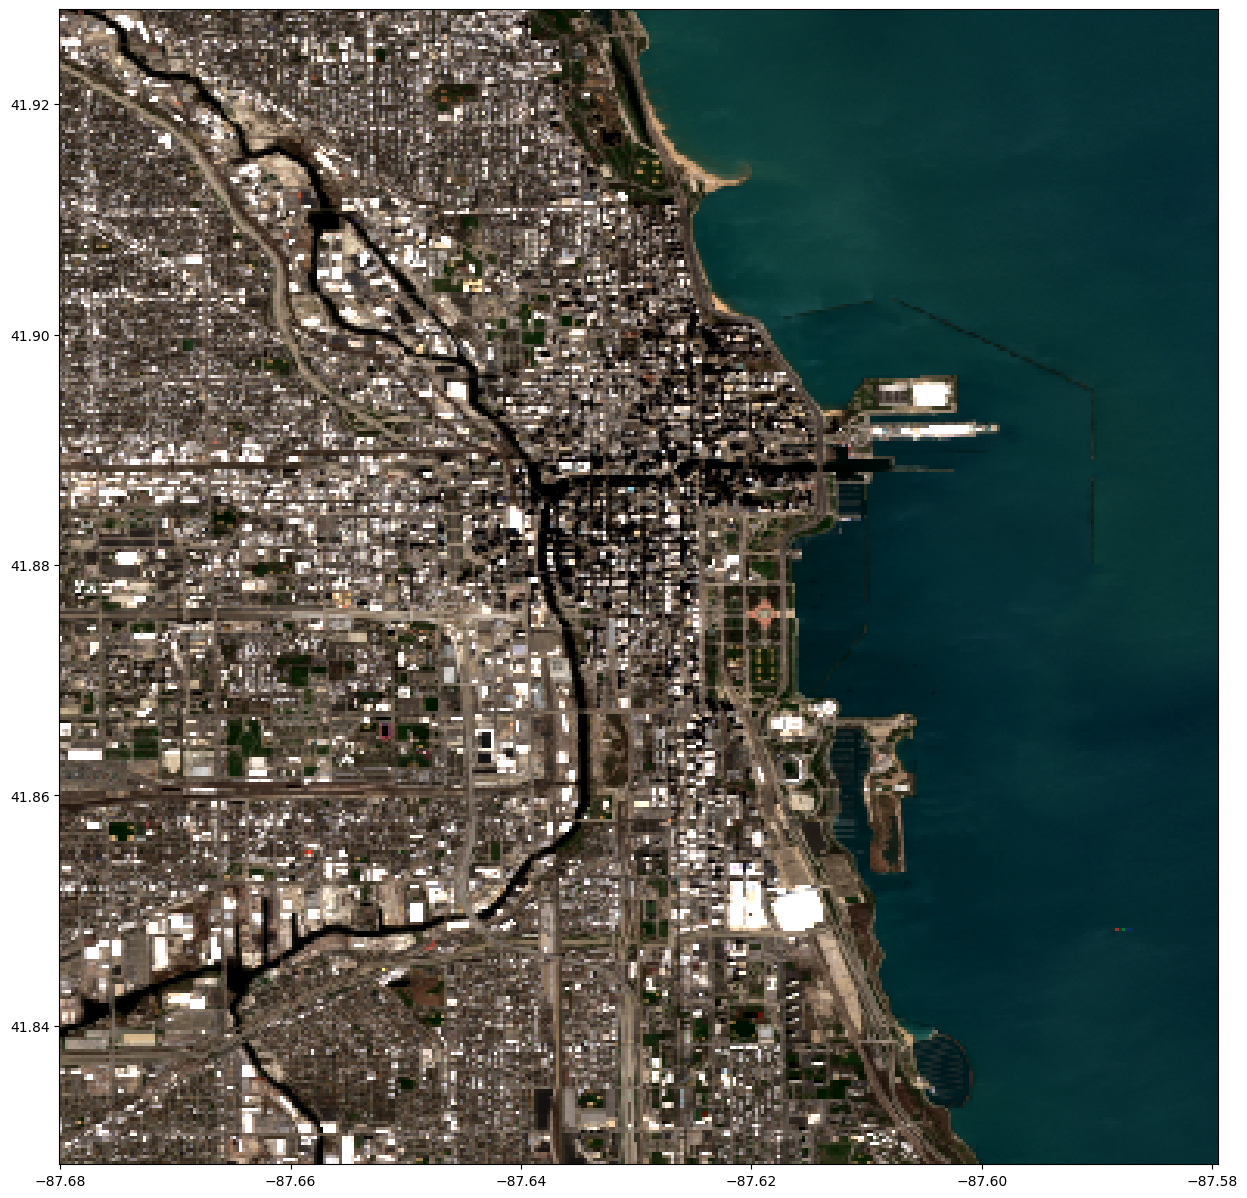

In [36]:
# SE Manhattan latitude, longitude and approximate size
lat = 41.8781
lon = -87.6298
sze = 0.1
_ = getSentinalS2SRImage(lon, lat, sze, 'Mhtn.tif')

f, ax = plt.subplots(figsize=(15,15))

chicago = rasterio.open('Mhtn.tif')
showRasterio(chicago.read(), ax = ax, transform=chicago.transform)

f.savefig('Mhtn.png', bbox_inches='tight')

chicago.close()

# delete!
!rm Mhtn.tif
!rm Mhtn.png